# K-Arm no-brown player vs Dummy player

The code used to implement the k-arm algorithm is inspired from the excercises in the Coursera course "Fundamentals of Reinforcement Learning" created by the University of Alberta (link [here](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning)).

In [1]:
import os

os.chdir('..')

from monosim.player import Player
from monosim.board import get_board, get_roads, get_properties, get_community_chest_cards, get_bank
import random
import pandas as pd
import numpy as np
from scipy.stats import binom_test
from tqdm import tqdm

import seaborn as sns
sns.set()

# Greedy agent

Here we modify a player implementing a simple greedy K-arm algorithm. In particular, the player learns through playing whether it's convenient to buy a brown property or not. The player is unaware of any state of the game (neither their state nor their opponent's). This is a big simplification of the game, as unlikely a game's outcome is determined by modifying the behaviour on whether a player buys a brown property or not. Also, decisions need to be made by observing the player and the opponent's state. This is just an example to show how to modify a player implementing Reinforcement Learning (RL) based algorithms.

The action to be taken by the player, when ending in a brown cell with no owner is "buy" or "do not buy". This can be formalized as:

$A_t = 1 \quad (Buy)$ \
$A_t = 0 \quad (Do Not Buy)$

The reward ($R_n$) is 1 if the player wins and 0 otherwise. The game can get in stalemate with the current impementation, in which case no reward is provided by the environment, and the Q-values not updated.

We're trying to estimate the expected reward for each action:

$q_*(a) = \mathop{\mathbb{E}} [R_t|A_t=a]$

and since we're implementing a simple greedy algorithm, the action will be selected as $A_t \doteq \underset{a}{\arg\max} Q_t(a)$

The use an incremental sample-average method to estimate the action-values as follow:

$Q_n+1 = Q_n+\frac{1}{n}(R_n-Q_n))$

## Modify player

Here we modify the Player class to implement the RL-based player.

#### Decorate buy() function

Creating a decorator used to modify the buy() function. This function will run the RL trained action when the player ends in a brown cell, which is not owned by other players. When the player doesn't end in a brown road, the default buy() behaviour will be used. When the player ends in a brown cell, the function brown_k_arm_action() is run, which is implemented below.

In [2]:
def modify_buy(buy):
    def _wrapper(self, dict_road_info, road_name):
        if dict_road_info['color'] == 'brown':
            action = self.brown_k_arm_action()
            if action == 1:
                buy(self, dict_road_info, road_name)
            else:
                pass
        else:
            buy(self, dict_road_info, road_name)
    return _wrapper

Inherit the class Player_brown_k_arm_greedy from Player. The function reset_val is used to set the player's state to default (e.g., cash=1500, 0 owned roads, etc.). Instead of re-creating a new Player object for each game, we reset the state of the existing Player object. This is important since we are adding four new state variables (q_values, count_actions, won_last_game_with_brown, last_action) which cannot be erased after each game. In particular, the list q_values contains the action-values which need to be incrementally updated.

The new variables are:

* q_values = list of 2 elements, containing the action-value for 0 (do not buy) and 1 (buy)
* count_actions = count how many times each action has been taken
* won_last_game_with_brown = 0 if the previous game was lost, 1 otherwise
* last_action = 0 if the last action was "do not buy brown road", 1 otherwise

The function update_q_values() updates the action-values, and it's run only when the player ends in a brown property without an owner. The function brown_k_arm_action uses the trained value-actions to decide wich action to take.

In [3]:
class Player_brown_k_arm_greedy(Player):
    def __init__(self, name, number, bank, dict_board, dict_roads, dict_properties, community_cards_deck):
        super().__init__(name, number, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
        self.q_values = [0, 0]  # Initially the player doesn't know which is the best action
        self.count_actions = [0, 0]
        self.won_last_game_with_brown = 0
        self.last_action = 0
        
    def reset_val(self, name, number, bank, dict_board, dict_roads, dict_properties, community_cards_deck):
        """ Reset Player's info (cash, properties, etc.). This function is used to reset
            the player's information, so that at each game we don't have to create a new
            Player object.
        """
        super().__init__(name, number, bank, dict_board, dict_roads, dict_properties, community_cards_deck)

    def update_q_values(self):
        """ Implement sample-average method. Update the q-value every time the player ends in a brown cell.
            The q-value is updated greedily, using the equation above.
        """
        q_value_old = self.q_values[self.last_action]
        self.count_actions[self.last_action] += 1
        reward = self.won_last_game_with_brown
        q_value_new = q_value_old + (1/self.count_actions[self.last_action]) * (reward - q_value_old)
        self.q_values[self.last_action] = q_value_new
        
    def brown_k_arm_action(self):
        """ Select an action based on the most recently updated q-values. The action is chosen greedily, getting
            the action with the maximum q-value all the times. This leads to no exploration by the agent, which
            will always select the last best-action.
        """
        if self.q_values[0] == self.q_values[1]:
            new_action = random.randint(0, 1)
        else:
            new_action = np.argmax(self.q_values)
        self.last_action = new_action
        return new_action
    
    #  Decorate buy() function.
    buy = modify_buy(Player.buy)

Implementing the reset_val() function also for the not-RL based player.

In [4]:
class Player_dummy(Player):
    def reset_val(self, name, number, bank, dict_board, dict_roads, dict_properties, community_cards_deck):
        """ Reset Player's info (cash, properties, etc.). This function is used to reset
            the player's information, so that at each game we don't have to create a new
            Player object.
        """
        super().__init__(name, number, bank, dict_board, dict_roads, dict_properties, community_cards_deck)

We run 10K simulations where at each iteration the seed of the random value is changed. This will modify the values of the dice used in each game, providing different games results. At the end of the simulation, we compare the number of times each player has won the game. We randomize which player starts first to further avoid bias in the results.

Note: We set a maximum number of turns equal to 1000 because there are situations in which the game doesn't end. This is possible in the game of Monopoly, though the number of times this happens might depend on the implementation as well. For now, we analyze results filtering out the occurrences where the game didn't end.
    
Player 1 is the dummy player and player 2 is the RL-based player. The action-values for player 2 are not updated when the game ends in stalemate.

In [5]:
list_results = []
list_scores = [0]
list_averages = []          #  Keep track of the average reward (just for reporting/plotting purpose)
count_games_with_end = 0
list_actions = []           #  Keep track of the actions taken by player 2 (just for reporting purpose)

for seed in tqdm(range(0, 10000)):
    random.seed(seed)
    bank = get_bank()
    dict_board = get_board()
    dict_roads = get_roads()
    dict_properties = get_properties()
    dict_community_chest_cards = get_community_chest_cards()
    community_cards_deck = list(dict_community_chest_cards.keys())
    if seed == 0:
        player1 = Player_dummy('player1', 1, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
        player2 = Player_brown_k_arm_greedy('player2', 2, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
    else:
        player1.reset_val('player1', 1, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
        player2.reset_val('player2', 2, bank, dict_board, dict_roads, dict_properties, community_cards_deck)

    player1.meet_other_players([player2])
    player2.meet_other_players([player1])

    list_players = [player1, player2]
    random.shuffle(list_players)  # Shuffle so that player1 doesn't always start first

    idx_count = 0
    while not player1.has_lost() and not player2.has_lost() and idx_count < 1000:
        for player in list_players:
            player.play()
        idx_count += 1
    
    if player1.has_lost() or player2.has_lost():
        count_games_with_end += 1
        if player1.has_lost():
            list_results.append((seed, 'player1_lost', list_players[0]._name))
            player2.won_last_game_with_brown = 1
            list_scores.append(list_scores[-1] + 1)
        else:
            list_results.append((seed, 'player2_lost', list_players[0]._name))
            player2.won_last_game_with_brown = 0
            list_scores.append(list_scores[-1] + 0)
        player2.update_q_values()
        list_averages.append(list_scores[-1]/count_games_with_end)
        list_actions.append(player2.last_action)
    else:
        list_results.append((seed, 'nobody_lost', list_players[0]._name))

100%|██████████| 10000/10000 [00:32<00:00, 309.33it/s]


The plot below shows the average reward throw time. The average reward is estimated only when the player wins or loses, discarding the situations in which the game doesn't end.

Text(0, 0.5, 'Average reward')

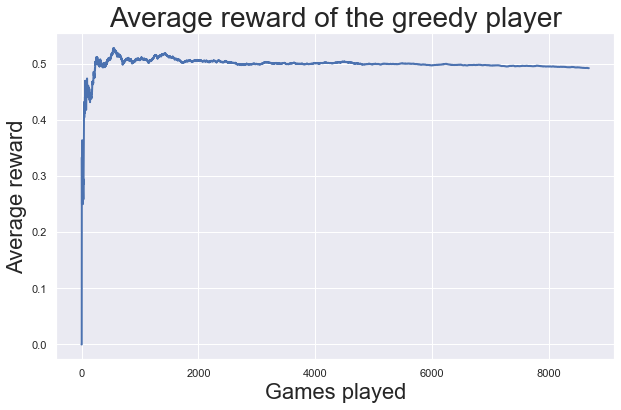

In [6]:
ser_avg_reward = pd.Series(list_averages, name='average_reward')

ax = ser_avg_reward.plot(figsize=(10, 6), linewidth=2)
ax.set_title('Average reward of the greedy player', fontsize=28)
ax.set_xlabel('Games played', fontsize=22)
ax.set_ylabel('Average reward', fontsize=22)

# fig = ax.get_figure()
# fig.savefig('images/k_arm_greedy_no_brown_avg_reward.png')

It should be noted that the player 2 always decides to buy the brown property (action=1).

In [7]:
print('Player 2 choses action 1 (buy brown) {} times out of {}'.format(sum(list_actions), len(list_actions)))

Player 2 choses action 1 (buy brown) 8679 times out of 8679


This is due to how the greedy algorithm works, where each time the action with the highest action-value is chosen. Since the first action of player 2 is buy(), ending in a victory, the action-value for the action "buy" is updated, getting higher than 0. This is the exploitation-exploration dilemma, where the agent greedily decides to choose the action with the highest reward (exploitation), without trying to embrace different behaviours (exploration).

Player 2 finally follows the same strategy as player 1 (buy alwasy), so it behaves exactly like a dummy player, hence player 2 is not statistically stronger than player 1.

In [8]:
df_res = pd.DataFrame(list_results, columns=['seed', 'lost_player', 'starting_player'])
n_lost_p1 = df_res[df_res.lost_player == 'player1_lost'].shape[0]
n_lost_p2 = df_res[df_res.lost_player == 'player2_lost'].shape[0]
count_start_p1 = df_res[(df_res.starting_player == 'player1') & (df_res.lost_player != 'nobody_lost')].shape[0]
count_start_p2 = df_res[(df_res.starting_player == 'player2') & (df_res.lost_player != 'nobody_lost')].shape[0]

print('player 1 started {} times and lost {} times'.format(count_start_p1, n_lost_p1))
print('player 2 started {} times and lost {} times'.format(count_start_p2, n_lost_p2))
print('nobody lost {} times'.format(df_res[df_res.lost_player == 'nobody_lost'].shape[0]))

player 1 started 4320 times and lost 4271 times
player 2 started 4359 times and lost 4408 times
nobody lost 1321 times


In [9]:
binom_test(x=n_lost_p1, n=n_lost_p1+n_lost_p2, p=1/2, alternative='two-sided')

0.14433079836105622

# Epsilon-Greedy agent

Here we implement an epsilon-greedy K-arm algorithm. Unlike in the previous section, we do not select the action with the highest q-value. Instead, the action is chosen at random with probability $ \epsilon$ (in this section we use $ \epsilon=0.5$). In particular, the action is selected using the following rule:

$\left\{\begin{matrix} \underset{a}{\arg\max} \ Q(a)
 & \ with \ probability \ 1- \epsilon \\ 
 random \ action & \ with \ probability \ \epsilon \ \ \ \ \ \
\end{matrix}\right.
$

This allows the agent to explore multiple actions at different times, instead of greedily choosing always the last best action, allowing it not to get stuck on the same decision.

We inherit the Player_brown_k_arm_epsilon_greedy from the previously created class Player_brown_k_arm_greedy (previously inherited from the class Player). This allows us to save some code, as the only things we need to modify are: 1) function brown_k_arm_action, 2) add the epsilon variable to the class.

In [10]:
class Player_brown_k_arm_epsilon_greedy(Player_brown_k_arm_greedy):
    def __init__(self, name, number, bank, dict_board, dict_roads, dict_properties, community_cards_deck):
        super().__init__(name, number, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
        self.epsilon = 0.5
        
    def brown_k_arm_action(self):
        """ Select action randomly with probability epsilon, or use the greedy algorirhm with probability
            - - epsilon.
        """
        if self.q_values[0] == self.q_values[1]:
            new_action = random.randint(0, 1)
        else:
            rnd = np.random.random()
            if rnd < self.epsilon:
                new_action = np.random.randint(0, len(self.q_values))
            else:
                new_action = np.argmax(self.q_values)
                
        self.last_action = new_action
        return new_action
    
    #  Decorate buy() function.
    buy = modify_buy(Player.buy)

In [11]:
list_results = []
list_scores = [0]
list_averages = []          #  Keep track of the average reward (just for reporting/plotting purpose)
count_games_with_end = 0
list_actions = []           #  Keep track of the actions taken by player 2 (just for reporting purpose)

for seed in tqdm(range(0, 10000)):
    random.seed(seed)
    bank = get_bank()
    dict_board = get_board()
    dict_roads = get_roads()
    dict_properties = get_properties()
    dict_community_chest_cards = get_community_chest_cards()
    community_cards_deck = list(dict_community_chest_cards.keys())
    if seed == 0:
        player1 = Player_dummy('player1', 1, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
        player2 = Player_brown_k_arm_epsilon_greedy('player2', 2, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
    else:
        player1.reset_val('player1', 1, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
        player2.reset_val('player2', 2, bank, dict_board, dict_roads, dict_properties, community_cards_deck)

    player1.meet_other_players([player2])
    player2.meet_other_players([player1])

    list_players = [player1, player2]
    random.shuffle(list_players)  # Shuffle so that player1 doesn't always start first

    idx_count = 0
    while not player1.has_lost() and not player2.has_lost() and idx_count < 1000:
        for player in list_players:
            player.play()
        idx_count += 1
    
    if player1.has_lost() or player2.has_lost():
        count_games_with_end += 1
        if player1.has_lost():
            list_results.append((seed, 'player1_lost', list_players[0]._name))
            player2.won_last_game_with_brown = 1
            list_scores.append(list_scores[-1] + 1)
        else:
            list_results.append((seed, 'player2_lost', list_players[0]._name))
            player2.won_last_game_with_brown = 0
            list_scores.append(list_scores[-1] + 0)
        player2.update_q_values()
        list_averages.append(list_scores[-1]/count_games_with_end)
        list_actions.append(player2.last_action)
    else:
        list_results.append((seed, 'nobody_lost', list_players[0]._name))

100%|██████████| 10000/10000 [00:32<00:00, 310.39it/s]


Text(0, 0.5, 'Average reward')

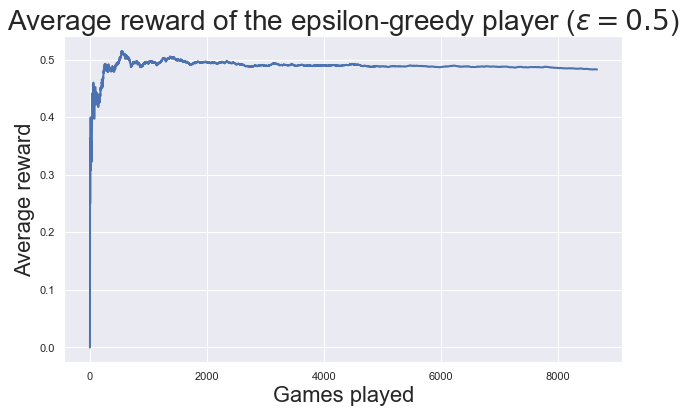

In [12]:
ser_avg_reward_eps05 = pd.Series(list_averages, name='average_reward')

ax = ser_avg_reward_eps05.plot(figsize=(10, 6), linewidth=2)
ax.set_title('Average reward of the epsilon-greedy player ($\epsilon=0.5$)', fontsize=28)
ax.set_xlabel('Games played', fontsize=22)
ax.set_ylabel('Average reward', fontsize=22)

# fig = ax.get_figure()
# fig.savefig('images/k_arm_epsilon_greedy_05_no_brown_avg_reward.png')

In [13]:
print('Player 2 choses action 1 (buy brown) {} times out of {}'.format(sum(list_actions), len(list_actions)))

Player 2 choses action 1 (buy brown) 7299 times out of 8673


In [14]:
df_res = pd.DataFrame(list_results, columns=['seed', 'lost_player', 'starting_player'])
n_lost_p1 = df_res[df_res.lost_player == 'player1_lost'].shape[0]
n_lost_p2 = df_res[df_res.lost_player == 'player2_lost'].shape[0]
count_start_p1 = df_res[(df_res.starting_player == 'player1') & (df_res.lost_player != 'nobody_lost')].shape[0]
count_start_p2 = df_res[(df_res.starting_player == 'player2') & (df_res.lost_player != 'nobody_lost')].shape[0]

print('player 1 started {} times and lost {} times'.format(count_start_p1, n_lost_p1))
print('player 2 started {} times and lost {} times'.format(count_start_p2, n_lost_p2))
print('nobody lost {} times'.format(df_res[df_res.lost_player == 'nobody_lost'].shape[0]))

player 1 started 4317 times and lost 4191 times
player 2 started 4356 times and lost 4482 times
nobody lost 1327 times


The random choice between the "buy" and "do-not-buy" brown properties leads player 2 to lose several games. Unlike before, the null hypothesis in the statistical test is rejected, since player 1 is statistically stronger than player 2.

In [15]:
binom_test(x=n_lost_p1, n=n_lost_p1+n_lost_p2, p=1/2, alternative='two-sided')

0.0018443039790837989

Though player 2 loses a few games, this allows the agent to test what's the best strategy overall, the q-values for both the action is updated. Looking at the final q-values, it can be noted that the "buy" action has the highest value, suggesting the buying the brown properties is the best action. It should also be noted that the q-value for the "do-not-buy action" is relatively high. Intuitively, this can be explained by the fact that buying or not buying properties of a specific colour is not a very "granular" action, and there can be several occasions when even not buying brown colour, a player can win a game. Better and more specific strategies should be selected (e.g., buy/do-not-buy a road/station/utility) or having an ad-hoc action for each situation (see contextual bandits).

In [16]:
player2.q_values

[0.42649199417758316, 0.49390327442115356]

# Epsilon-Greedy agent (multiple $\epsilon$ values)

Here we compare results using the epsilon-greedy agent with different values for $\epsilon$.

In [17]:
list_series = []            #  Store Pandas Series with rewards for each epsilon

for eps in [0.1, 0.5, 0.7, 0.9]:
    list_results = []
    list_scores = [0]
    list_averages = []          #  Keep track of the average reward (just for reporting/plotting purpose)
    count_games_with_end = 0
    for seed in tqdm(range(0, 10000)):
        random.seed(seed)
        bank = get_bank()
        dict_board = get_board()
        dict_roads = get_roads()
        dict_properties = get_properties()
        dict_community_chest_cards = get_community_chest_cards()
        community_cards_deck = list(dict_community_chest_cards.keys())
        if seed == 0:
            player1 = Player_dummy('player1', 1, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
            player2 = Player_brown_k_arm_epsilon_greedy('player2', 2, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
            player2.epsilon = eps
        else:
            player1.reset_val('player1', 1, bank, dict_board, dict_roads, dict_properties, community_cards_deck)
            player2.reset_val('player2', 2, bank, dict_board, dict_roads, dict_properties, community_cards_deck)

        player1.meet_other_players([player2])
        player2.meet_other_players([player1])

        list_players = [player1, player2]
        random.shuffle(list_players)  # Shuffle so that player1 doesn't always start first

        idx_count = 0
        while not player1.has_lost() and not player2.has_lost() and idx_count < 1000:
            for player in list_players:
                player.play()
            idx_count += 1

        if player1.has_lost() or player2.has_lost():
            count_games_with_end += 1
            if player1.has_lost():
                list_results.append((seed, 'player1_lost', list_players[0]._name))
                player2.won_last_game_with_brown = 1
                list_scores.append(list_scores[-1] + 1)
            else:
                list_results.append((seed, 'player2_lost', list_players[0]._name))
                player2.won_last_game_with_brown = 0
                list_scores.append(list_scores[-1] + 0)
            player2.update_q_values()
            list_averages.append(list_scores[-1]/count_games_with_end)
        else:
            list_results.append((seed, 'nobody_lost', list_players[0]._name))
    series_tmp = pd.Series(list_averages, name='average_reward')
    series_tmp.name = 'epsilon ' + str(eps)
    list_series.append(series_tmp)

100%|██████████| 10000/10000 [00:33<00:00, 302.48it/s]


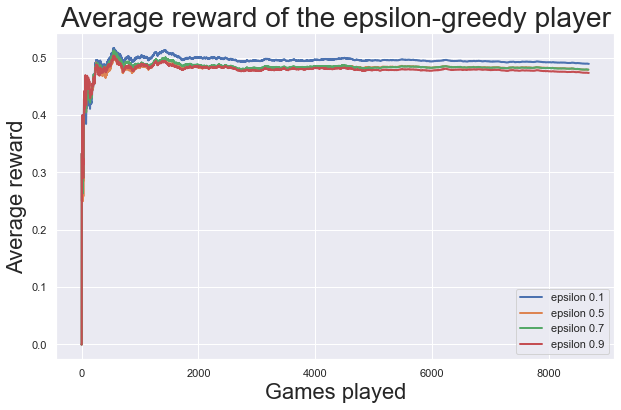

In [18]:
df_res = pd.concat(list_series, axis=1)

ax = df_res.plot(figsize=(10, 6), linewidth=2)
ax.set_title('Average reward of the epsilon-greedy player', fontsize=28)
ax.set_xlabel('Games played', fontsize=22)
ax.set_ylabel('Average reward', fontsize=22)

fig = ax.get_figure()
fig.savefig('images/k_arm_epsilon_greedy_multi_eps_no_brown_avg_reward.png')